In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler

In [ ]:
import urllib.request
import gzip
import numpy as np
import pickle


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}
dataset_dir = './mnist'    #データを保存する場所

for v in key_file.values():
    file_path = dataset_dir + '/' + v
    urllib.request.urlretrieve(url_base + v, file_path)

def load_img(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 784)

    return data

def load_label(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return labels

dataset = {}
dataset['train_img'] = load_img(key_file['train_img'])
dataset['train_label'] = load_label(key_file['train_label'])
dataset['test_img'] = load_img(key_file['test_img'])
dataset['test_label'] = load_label(key_file['test_label'])

save_file = dataset_dir + '/mnist.pkl'    #拡張子は.pkl
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)    #-1は最も高いプロトコルバージョンで保存することを指定している


## 2.3　パーセプトロンの実装  
* パーセプトロンとは、複数の0,1入力をもとに1つの0,1出力を返すアルゴリズムのこと

In [1]:
def AND(x1,x2):
    w1, w2, theta = .5, .5, .7
    tmp = x1 * w1 + x2 * w2 - theta
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [3]:
print(AND(0,0))
print(AND(1,1))
print(AND(1,0))
print(AND(0,1))

0
1
0
0


* 重みとバイアスを導入。行列式の形にする

2つの入力値$x_1,x_2$について、それぞれに対応する重み$w_1, w_2$をかけた和とバイアス($b$)の大小で出力を判断する。  
$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$

In [13]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

In [14]:
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {AND(m,n)}')

[0, 0] -> 0
[0, 1] -> 0
[1, 0] -> 0
[1, 1] -> 1


- 重み$w_n$は対応する入力値$x_n$それぞれの重要度を制御  
- バイアス$b$はそのニューロンの発火しやすさを制御

In [23]:
def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-.5, -.5])
    b = .7
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {NAND(m,n)}')

NAND
[0, 0] -> 1
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 0


In [33]:
def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([.5, .5])
    b = -.2
    tmp = b + np.sum(x * w)
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1

print('NAND')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> {OR(m,n)}')

NAND
[0, 0] -> 0
[0, 1] -> 1
[1, 0] -> 1
[1, 1] -> 1


* XOR:排他的論理和  
これは線型のパーセプトロンでは実装できない

| $x_1$ | $x_2$ | $y$ |  
| :---: | :---: | :---: |  
| 0 | 0 | 0 |  
| 1 | 0 | 1 |  
| 0 | 1 | 1 |  
| 1 | 1 | 0 |  

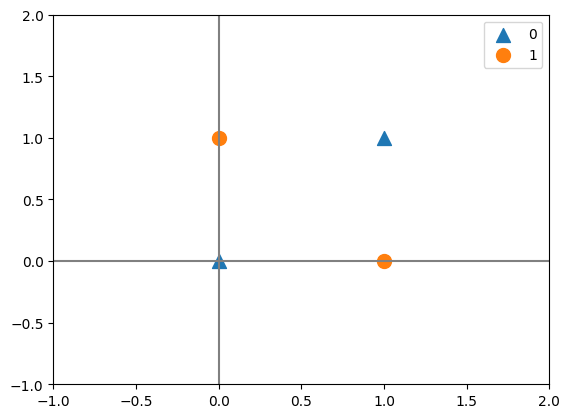

In [56]:
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.hlines(y=0,xmin=-5,xmax=5,colors='gray')
plt.vlines(x=0,ymin=-5,ymax=5,colors='gray')
plt.scatter(x=[0,1],y=[0,1],marker='^',s=100,label='0')
plt.scatter(x=[0,1],y=[1,0],marker='o',s=100,label='1')
plt.legend(loc='best')


* 上の図で、三角(出力が0)と丸(出力が1)を分ける直線が引けない

### 多層パーセプトロン
* パーセプトロンを組み合わせることで非線形の分離を実装可能  

In [63]:
def XOR(x1,x2):
    s1 = OR(x1,x2)
    s2 = NAND(x1,x2)
    y = AND(s1,s2)
    return y

print('XOR')
for m in range(2):
    for n in range(2):
        print(f'{[m,n]} -> AND:{AND(m,n)}, NAND:{NAND(m,n)}, OR:{OR(m,n)}, XOR:{XOR(m,n)}')

XOR
[0, 0] -> AND:0, NAND:1, OR:0, XOR:0
[0, 1] -> AND:0, NAND:1, OR:1, XOR:1
[1, 0] -> AND:0, NAND:1, OR:1, XOR:1
[1, 1] -> AND:1, NAND:0, OR:1, XOR:0


* 線型なパーセプトロンでも多層にすることで非線形な表現が可能。
* でも今のところ、パラメータ(重みやバイアス)の値は人間が期待する出力に合わせて調整している
* 最適なパラメータをデータから学習させることを考える

### ニューラルネットワーク

$$
y=
\left\{
\begin{array}{ll}
0 & (b + w_1 x_1 + w_2 x_2) \leqq 0 \\
1 & (b + w_1 x_1 + w_2 x_2) > 0
\end{array}
\right.
$$
を、以下のように変換する  

$$
a= b + w_1 x_1 + w_2 x_2
$$
$$
h(x) = \left\{
\begin{array}{ll}
0 & x \leqq 0 \\
1 & x > 0
\end{array}
\right.
$$
$$
y = h(a)
$$

$a$ : 入力信号の重み付き和(バイアス含む)を計算  
$h(x)$ : そのニューロンが発火する条件が指定されている**活性化関数**  
$y$ : 入力の重み付き和を活性化関数に引き渡した結果の出力  

* 活性化関数はさまざまな関数たりうるが、パーセプトロンはある閾値で出力が切り替わる**ステップ関数**を活性化関数として採用したNNだと言える
* ニューラルネットワークでは一般的に**シグモイド関数**が使われる  

$$
h(x)=\frac{1}{1+\exp(-x)}
$$

* ステップ関数とシグモイド関数を比較

In [72]:
def step_function(x:np.array):
    y = x > 0
    return y.astype(int)
def sigmoid(x:np.array):
    y = 1/(1+np.exp(-x))
    return y

In [70]:
x = np.array([1,0,.5,1.4,50])
step_function(x)

array([1, 0, 1, 1, 1])

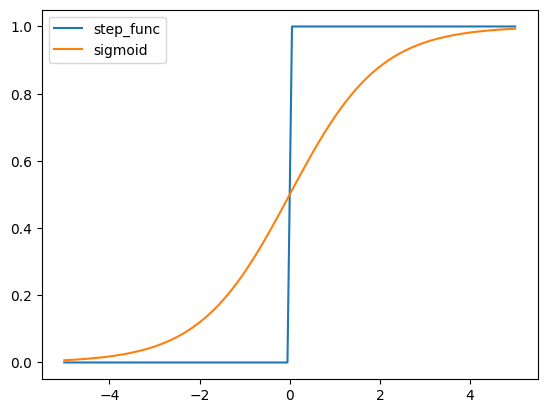

In [76]:
x=np.linspace(-5,5,100)
y_step=step_function(x)
y_sig=sigmoid(x)
plt.plot(x,y_step,label='step_func')
plt.plot(x,y_sig, label = 'sigmoid')
plt.legend(loc ='best')

- 最近のNNではReLU関数という関数が活性化関数で使われることが多い。<ins>**Re**</ins>ctified <ins>**L**</ins>inear <ins>**U**</ins>nit
$$
y=
\left\{
\begin{array}{ll}
0 & x\leqq 0 \\
x & x > 0
\end{array}
\right.
$$

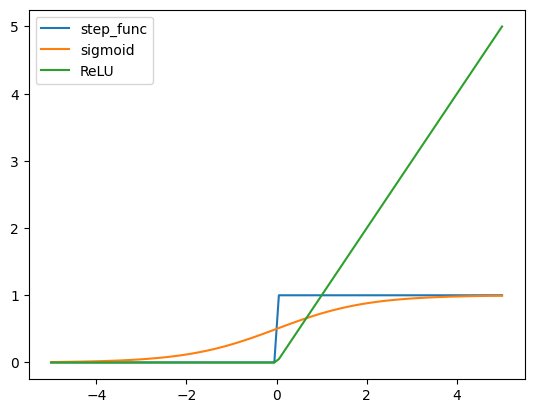

In [77]:
def relu(x):
    return np.maximum(x,0)

x=np.linspace(-5,5,100)
y_step=step_function(x)
y_sig=sigmoid(x)
y_relu=relu(x)
plt.plot(x,y_step,label='step_func')
plt.plot(x,y_sig, label = 'sigmoid')
plt.plot(x,y_relu, label = 'ReLU')
plt.legend(loc ='best')

### 多次元配列の計算

- NNの計算を行列で行うと１発で計算できる。
- 2つのインプット$x_1,x_2$に対して、それぞれ[$w_{11},w_{21}$],[$w_{12},w_{22}$],[$w_{13},w_{23}$]の重み付けをした出力$y_1,y_2,y_3$は以下のように求められる。

$$
\begin{pmatrix}
x_1 & x_2 \\
\end{pmatrix}
\begin{pmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
\end{pmatrix}
=
\begin{pmatrix}
y_1=x_1 \times w_{11}+x_2 \times w_{21} & y_2=x_1 \times w_{12}+x_2 \times w_{22} & y_3=x_1 \times w_{13}+x_2 \times w_{23}
\end{pmatrix}
$$

入力ベクトルのn番目のニューロンを出力ベクトルのm番目にするためにかかる重みwを$w_{nm}$

- おさらい  
入力に重みをかけてバイアスを足した値を活性化関数にかけた出力が出力値  
$$
output = h(input \times weight + bias)
$$
$$
Y=h(X \times W + B)
$$

### 適当な実装

#### まずは重み付き和

In [97]:
X = np.array([1.0, 0.5])
W1 = np.array([
    [.1, .3, .5],
    [.2, .4, .6]
])
B1 = np.array([.1, .2, .3])
A1 =np.dot(X, W1) + B1
A1

array([0.3, 0.7, 1.1])

#### 次に活性化関数 -> 第一層

In [98]:
Z1 = sigmoid(A1)
Z1

array([0.57444252, 0.66818777, 0.75026011])

#### 第１層の重み付き和→第二層へ

In [99]:
W2 = np.array([
    [.1, .4],
    [.2, .5],
    [.3, .6]
])
B2 = np.array([.1, .2])
A2 = np.dot(Z1,W2) + B2
Z2 = sigmoid(A2)

In [100]:
def identify_function(x):
    return x

#### 出力

In [101]:
W3 = np.array([
    [.1, .3],
    [.2, .4]
])
B2 = np.array([.1, .2])

Y = identify_function(np.dot(Z2,W3) + B2)
Y

array([0.31682708, 0.69627909])

#### ここまでを一気に実装する

In [44]:
def sigmoid(x:np.array):
    return 1/(1+np.exp(-x))

def identify_function(x):
    return x

def init_network():
    network = {}
    network['W1']=np.array([
        [.1, .3, .5],
        [.2, .4, .5],
    ])
    network['b1']=np.array([.1, .2, .3])
    network['W2']=np.array([
        [.1, .4],
        [.2, .5],
        [.3, .6]
    ])
    network['b2']=np.array([.1, .2])
    network['W3']=np.array([
        [.1, .3],
        [.2, .4]
    ])
    network['b3']=np.array([.1, .2])
    return network

def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = identify_function(a3)
    return y

In [103]:
network = init_network()
x=(1, .5)
y = forward(network, x)
print(y)

[0.31655918 0.69567667]


## 3.5 出力層

ニューラルネットワークは出力層を変えることで回帰にも分類にも応用可能。  
一般的に回帰の場合は恒等関数、分類のときはソフトマックス関数が用いられる

恒等関数＝入力値をそのまま返す関数
ソフトマックス関数
$$y_k=\frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)}$$
n個の入力がある時のk番目の出力には、全ての入力の指数関数の和が関係する

In [3]:
# ソフトマックス関数の実装
a = np.array([.3, 2.9, 4])
exp_a = np.exp(a)
sum_exp_a = np.sum(exp_a)
y = exp_a / sum_exp_a
print(y)

[0.01821127 0.24519181 0.73659691]


In [7]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

print(a)
print(softmax(a))

[0.3 2.9 4. ]
[0.01821127 0.24519181 0.73659691]


ソフトマックスの計算で登場するeの指数関数は莫大な値になってしまう。
以下の数式変換によって、任意の定数を足し引きしても元の出力と変わらないことを利用し、与えられた入力の最大値を引くことで計算量を節約する。
$$
\begin{align}
y_k &= \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)}\\
&= \frac{C \times exp(a_k)}{C \times \sum_{i=1}^{n}exp(a_i)}\\
&= \frac{exp(a_k+logC)}{\sum_{i=1}^{n}exp(a_i+logC)}\\
&= \frac{exp(a_k+C')}{\sum_{i=1}^{n}exp(a_i+C')}\\
&= \frac{exp(c_k)}{\sum_{i=1}^{n}exp(c_i)}\\
\end{align} \\
(c_k = a_k+C'とおく)
$$

In [12]:
a = np.array([1010,1000,990])
print(softmax(a))

[nan nan nan]


/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/1715826989.py:2: RuntimeWarning: overflow encountered in exp
  exp_a = np.exp(a)
/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/1715826989.py:4: RuntimeWarning: invalid value encountered in divide
  return exp_a / sum_exp_a


In [13]:
c = a - np.max(a)
exp_c = np.exp(c)
sum_exp_c = np.sum(exp_c)
y = exp_c / sum_exp_c
print(y)

[9.99954600e-01 4.53978686e-05 2.06106005e-09]


In [15]:
def softmax(a):
    a = a-np.max(a)
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

print(a)
print(softmax(a))

[1010 1000  990]
[9.99954600e-01 4.53978686e-05 2.06106005e-09]


ソフトマックス関数の特徴として、総和が1になる。
これによって、出力を確率として解釈することができ、最も大きな出力をもつクラスを分類問題の答えに割り当てることが可能。
一方で、ソフトマックス関数は単調増加関数であるため、最も大きな入力に対応する出力が最も大きい。
確率の出力値が不要で、<ins>最も確率が高い入力がどれか</ins>がわかれば良い場合はソフトマックス関数を省略するケースも多い。

出力層の数は、問題によって異なる。
クラス分類なら分類したいクラスの数だけ最終出力を用意する

## 3.6 手書き数字の認識 10クラス分類問題の実装

In [26]:
dataset.keys()

dict_keys(['train_img', 'train_label', 'test_img', 'test_label'])

In [34]:
pil=Image.fromarray(dataset['train_img'][0].reshape(28,28))
pil.show()

28×28pixelの数字の画像を推論する。
入力情報は各ピクセルの値なので$28 \times 28 = 784$、出力情報は0〜9の数字を当てるので10
隠れ層は任意だがテキストに従って、2層、50->100ニューロンにする

In [41]:
X_train, X_test, y_train, y_test = \
    dataset['train_img']/255.0, dataset['test_img']/255.0, \
    dataset['train_label'], dataset['test_label']
# 明度スコア0~255を255で割って0~1に正規化

In [62]:
def init_network(): # デモとして訓練ずみの重み,バイアスを使用
    with open('./mnist/sample_weight.pkl','rb') as f:
        network = pickle.load(f)
        return network

def predict(network, x):
    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3']

    a1 = np.dot(x, W1) + b1 # 入力に重みとバイアス
    z1 = sigmoid(a1) # 第一層の活性化関数
    a2 = np.dot(z1, W2) + b2 # 第一層の出力に重みとバイアス
    z2 = sigmoid(a2) # 第二層の活性化関数
    a3 = np.dot(z2, W3) + b3 # 第二層の出力に重みとバイアス
    y = softmax(a3) # 出力層の活性化関数
    return y

In [63]:
network = init_network()
y = predict(network,X_test[0])

In [65]:
np.argmax(y)

7

In [74]:
y_predicted = np.array([np.argmax(predict(network,x)) for x in X_test])

In [81]:
result = np.unique(y_test==y_predicted,return_counts=True)
result

(array([False,  True]), array([ 648, 9352]))

In [95]:
score = result[1][result[0]==True][0]/y_predicted.size
print(f'Accuracy = {score:.2%}')


Accuracy = 93.52%


In [96]:
print(
    X_test[0].shape,
    network['W1'].shape,
    network['b1'].shape,
    network['W2'].shape,
    network['b2'].shape,
    network['W3'].shape,
    network['b3'].shape,
)

(784,) (784, 50) (50,) (50, 100) (100,) (100, 10) (10,)


先の実装では、10000枚の画像を一つずつNNに通して計算していた。  
バッチ処理で、一気に100枚ずつNNに通すように回収する（計算速度の利点）

In [98]:
X_test[0:100].shape

(100, 784)

In [105]:
batch_size = 100
accuracy_cnt = 0

for i in range(0,len(X_test),batch_size):
    x_batch = X_test[i:i+batch_size]
    y_predicted = np.argmax(predict(network,x_batch),axis=1)
    accuracy_cnt += np.sum(y_predicted == y_test[i:i+batch_size])

In [106]:
accuracy_cnt/y_test.size

0.9352

In [107]:
batch_size = 10000
accuracy_cnt = 0

for i in range(0,len(X_test),batch_size):
    x_batch = X_test[i:i+batch_size]
    y_predicted = np.argmax(predict(network,x_batch),axis=1)
    accuracy_cnt += np.sum(y_predicted == y_test[i:i+batch_size])
accuracy_cnt/y_test.size

0.9352

In [109]:
y_predicted=np.argmax(predict(network,X_test),axis=1)
accuracy_cnt = np.sum(y_predicted==y_test)
accuracy_score = accuracy_cnt/y_predicted.size
print(f'{accuracy_score:.2%}')

93.52%


え、そもそものテストデータを(10000個,784pixel)の行列とみなしたらわざわざバッチ処理なんて小面倒なことしなくても一気に計算できるのでは？

## 4.2 損失関数
一般的な機械学習は人間の手で加工した特徴量を突っ込んで機械が学習する。  
特徴量エンジニアリングが必須。  
一方でNNは、特徴量の作成までも機械が行うend to end ML。  
NNにおいては、損失関数という**精度がどれだけ悪いか**という指標を用いて、損失関数を最小化するように機械が勝手にチューニングを行う。
損失関数には複数あり、よく用いられるものとして以下がある。
1. 二乗和誤差
1. 交差エントロピー誤差

### 二乗和誤差
$$
E = \frac{1}{2} \sum\limits_{k} (y_k-t_k)^2
$$
$t$は教師データ、$y$はNNの出力を表す。
手書き数字を当てる問題だと、$y$はsoftmax関数の出力で0~9それぞれに該当する確率が出てくる。
$$
y = \begin{pmatrix}
 0の確率 \\ 1の確率 \\ 2の確率 \\ 3の確率 \\ 4の確率 \\ 5の確率 \\ 6の確率 \\ 7の確率 \\ 8の確率 \\ 9の確率
\end{pmatrix}
=
\begin{pmatrix}
 0.1 \\ 0.01 \\ 0.4 \\ 0.2 \\ 0.1 \\ 0.8 \\ 0.1 \\ 0.03 \\ 0.02 \\ 0.4
\end{pmatrix}
$$
一方で$t$は正解データのone hot encodingデータ。
$$
t =
\begin{pmatrix}
 0 \\ 1 \\ 2 \\ 3 \\ 4 \\ 5 \\ 6 \\ 7 \\ 8 \\ 9
\end{pmatrix}
=
\begin{pmatrix}
 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$
それぞれの数字に対して正解と確率の差の二乗を足し込んだ値を最小化していく、という考え方。
2で割っている理由は、この後出てくる勾配法にて、この損失関数の傾きを計算する際に微分する際、計算が簡単になるために慣習としてつけているらしい。

In [110]:
def sum_squared_error(pred,train):
    return 0.5 * np.sum((pred-train)**2)

### 交差エントロピー誤差
$$
E = -\sum\limits_{k} t_k\log_e{y_k}
$$
$t,y$は二乗和誤差と同じで、不正解ラベルのtは0なので、単純に正解ラベルの予測確立の自然対数$-\log_e{y_{cerrect}}$  
確率が最大($y_{cerrect}=1$)になると$\log{1}=0$で損失関数が最小になる

/var/folders/hs/ztz399gn2s1gkzbjjfpyc5_w0000gn/T/ipykernel_3422/4058711112.py:2: RuntimeWarning: divide by zero encountered in log
  y = (-1)*np.log(x)


Text(0, 0.5, 'value of loss function')

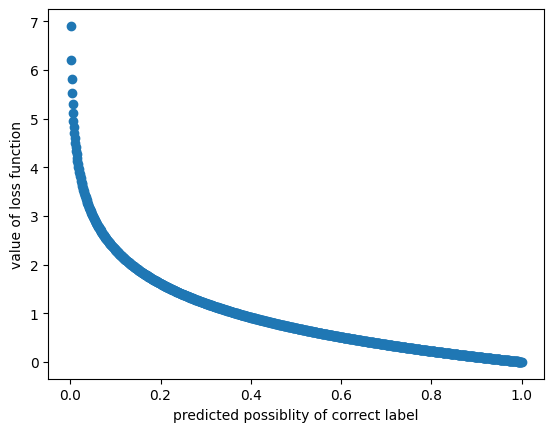

In [113]:
x = np.linspace(0,1,1000)
y = (-1)*np.log(x)
plt.scatter(x,y)
plt.xlabel('predicted possiblity of correct label')
plt.ylabel('value of loss function')

In [114]:
def cross_entropy_error(pred,train):
    pred=pred+(1e-7) #log0の計算にならないように微小な値を足しておく
    return -np.sum(train*np.log(pred))